# Staff-Graded Matrix Completion

### Part (a)

In [1]:
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

# Import data as pandas df, convert to np.array
data = np.asarray(pd.read_csv('MovieReviewMat.csv', header=None))
titles = data[0,1:] # Save movie titles
data = data[1:,1:] # Save all rows except movie titles

# Replace string 'NA' and blank with np.nan
data[data == 'NA'] = np.nan
data[data == ''] = np.nan

# Remove header rows and column, and ensure all values are float type
matrix = data[1:,:].astype(float)

# Find values
max_val = np.nanmax(matrix)
min_val = np.nanmin(matrix)
avg_val = np.nanmean(matrix)

print(f'Maximum Value: {max_val}')
print(f'Minimum Value: {min_val}')
print(f'Average Value: {avg_val}')


Maximum Value: 5.0
Minimum Value: 0.5
Average Value: 3.297080189685473


The maximum rating in the data is 5.0, and the minimum rating is 0.5

The average rating is approximately 3.3

### Part (b)

In [2]:
# Find genre labels and scores for individual
headers = data[0,:]
scores_1460 = matrix[1460,:]
scores_43 = matrix[43,:]

def fivestar_review_count(headers, scores) -> list:
    # Concatenate all genre labels into one string
    string = str()
    for cell in headers:
        string += cell + '|'

    # Create function that finds indeces of pipe character in concatenated string,
    # returns indeces in a list
    def find_letter(string, char):
        return [i for i, letter in enumerate(string) if letter == char]

    # Use function to find indeces list
    indeces = find_letter(string, '|')

    # Initialize empty list
    genre_list = list()

    # Fill empty list with non-unique genre names
    for i in range(len(indeces)):
        if i > 0:
            genre_list.append(string[indeces[i-1]+1:indeces[i]])
        else:
            genre_list.append(string[:indeces[i]])
                            
    # Unique-ify the genre list
    unique_genres = set(genre_list)
    unique_genres = list(unique_genres)
    unique_genres.sort()

    # Create dictionary of unique genre names and placeholder zero counts
    reviews_dict = {'Genre': unique_genres,
                    'Score': list(np.repeat(0, len(unique_genres)))}
    # Convert dictionary to data frame
    fivestar_reviews = pd.DataFrame(reviews_dict)

    # Loop through headers and unique genres to find the five-star review count
    # for each unique genre
    name_pair = list()
    i = 0
    for genre in fivestar_reviews['Genre']:
        j = 0
        for genre_combo in headers:
            if genre in genre_combo and scores[j] == 5:
                fivestar_reviews['Score'][i] += 1
                if len(name_pair) < 2:
                    name_pair.append(titles[j])
            j += 1
        i += 1

    # Sort by score (desc) and return
    fivestar_reviews = fivestar_reviews.sort_values(by=['Score'], ascending=False)
    return [fivestar_reviews, name_pair]


print(f'Five-star reviews for individual indexed at 1460, by genre:\n {fivestar_review_count(headers, scores_1460)[0]}')
print(f'\nTwo movies rated five stars by individual indexed at 1460:\n{fivestar_review_count(headers, scores_1460)[1]}')
print('\n\n')
print(f'Five-star reviews for individual indexed at 43, by genre:\n {fivestar_review_count(headers, scores_43)[0]}')
print(f'\nTwo movies rated five stars by individual indexed at 43:\n{fivestar_review_count(headers, scores_43)[1]}')

Five-star reviews for individual indexed at 1460, by genre:
                  Genre  Score
8                Drama     11
15             Romance      4
4             Children      2
1               Action      2
13             Musical      1
2            Adventure      1
18                 War      1
17            Thriller      1
6                Crime      1
16              Sci-Fi      1
9              Fantasy      1
0   (no genres listed)      0
14             Mystery      0
10           Film-Noir      0
12                IMAX      0
11              Horror      0
7          Documentary      0
5               Comedy      0
3            Animation      0
19             Western      0

Two movies rated five stars by individual indexed at 1460:
['Rob Roy (1995)', 'War of the Worlds, The (1953)']



Five-star reviews for individual indexed at 43, by genre:
                  Genre  Score
5               Comedy      5
8                Drama      2
2            Adventure      1
6              

The first table above, which counts only five-star reviews, shows that indvidual 1460 tends to give the most five-star reviews to movies in the Drama genre. Two movies that this individual rates with a 5 are *Rob Roy* and *War fo the Worlds*.

The second table shows that individual 43 gives the most five-star reviews to movies in the Drama genre, similar to the other individual. However, individual 43 seems to have given far fewer five-star reviews than individual 1460. Two movies that this individual rates with a 5 are *Jack* and *Howard the Duck*.

### Part (c)

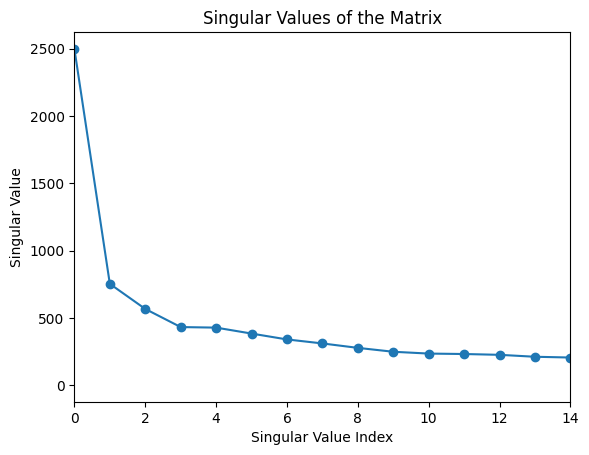

In [3]:
import matplotlib.pyplot as plt

# Reset matrix to orignal from csv
matrix = data[1:,:].astype(float)

# Replace NaN values with zeroes
matrix = np.nan_to_num(matrix)

# Compute the singular values using SVD
singular_values = np.linalg.svd(matrix, compute_uv=False)

# Plot the singular values
plt.plot(singular_values, marker='o')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of the Matrix')

# Set the x-axis limits to show only the first 15 singular values
plt.xlim(0, 14)

plt.show()

I estimate that we will find two broad classes of individuals in the rating data: Those who give five-star reviews to many different movies, and those who give five-star reviews to only one or two genres of movies.

This phenomenon could be explained by the proclivity of some people to rather freely give a five-star rating to a film. Additionally, some people are movie enthusiasts, tending to watch more movies than the average individual and thus having more opportunity to give any review at all.

### Part (d)

In [4]:
# Set estimated ideal k value according to Part (c)
k = 2

# Replace NaN values with zeroes
matrix = np.nan_to_num(matrix)

# Perform SVD
u, s, vt = np.linalg.svd(matrix)

# Reconstruct
matrix_reconst = u[:,0:k] @ np.diag(s[0:k]) @ vt[0:k,:]
print(f'Jumanji rating:\n{matrix_reconst[43,1]}')

Jumanji rating:
1.5477808406006486


From this SVD analysis, we estimate that this user would give the movie *Jumanji* a rating of approximately 1.55

In [5]:
def reconstruct_compare(matrix_reconst):
    # Reset matrix to orignal from csv
    matrix = data[1:,:].astype(float)
    
    # Create a boolean mask for NaN values in original matrix
    mask = np.isnan(matrix)

    # Find the non-NaN values using the inverse of the mask
    non_nan_orig_values = matrix[~mask]
    non_nan_recon_values = matrix_reconst[~mask]

    # Find average difference
    avg_diff = math.sqrt(sum((non_nan_orig_values - non_nan_recon_values)**2) / len(mask[mask == False]))
    return avg_diff

print(f'Average difference:\n{reconstruct_compare(matrix_reconst)}')



Average difference:
2.0222243742065205


Under the current parameters, we find the average difference to be approximately 2.02

### Part (e)

In [6]:
# Reset matrix to orignal from csv
matrix = data[1:,:].astype(float)

# Replace string 'NA' and blank with np.nan
data[data == 'NA'] = np.nan
data[data == ''] = np.nan

# Calculate the column averages (ignoring NaN values)
column_averages = np.nanmean(matrix, axis=0)

# Find the indices of NaN values in each column
nan_indices = np.isnan(matrix)

# Replace NaN values with respective column averages
for col_idx in range(matrix.shape[1]):
    column_mask = nan_indices[:, col_idx]
    matrix[column_mask, col_idx] = column_averages[col_idx]


# Perform SVD
u, s, vt = np.linalg.svd(matrix)

# Reconstruct
matrix_reconst = u[:,0:k] @ np.diag(s[0:k]) @ vt[0:k,:]
print(f'Jumanji rating:\n{matrix_reconst[43,1]}')

Jumanji rating:
2.41064604250896


From this SVD analysis, we estimate that this user would give the movie *Jumanji* a rating of approximately 2.41

In [7]:
print(f'Average difference:\n{reconstruct_compare(matrix_reconst)}')

Average difference:
0.8523627153511475


Under the current parameters, we find the average difference to be approximately 0.85

### Part (f)

In [8]:
# Reset matrix to orignal from csv
matrix = data[1:,:].astype(float)

# Replace string 'NA' and blank with np.nan
data[data == 'NA'] = np.nan
data[data == ''] = np.nan

# Calculate the row averages (ignoring NaN values)
row_averages = np.nanmean(matrix, axis=1)

# Find the indices of NaN values in each row
nan_indices = np.isnan(matrix)

# Replace NaN values with respective row averages
for row_idx in range(matrix.shape[0]):
    row_mask = nan_indices[row_idx, :]
    matrix[row_idx, row_mask] = row_averages[row_idx]

# Perform SVD
u, s, vt = np.linalg.svd(matrix)

# Reconstruct
matrix_reconst = u[:,0:k] @ np.diag(s[0:k]) @ vt[0:k,:]
print(f'Jumanji rating:\n{matrix_reconst[43,1]}')

Jumanji rating:
2.7572223883978304


From this SVD analysis, we estimate that this user would give the movie *Jumanji* a rating of approximately 2.76

In [9]:
print(f'Average difference:\n{reconstruct_compare(matrix_reconst)}')

Average difference:
0.8644732783536794


Under the current parameters, we find the average difference to be approximately 0.86

### Part (g)

Replacing missing values with zeroes assumes that those reviewer-movie combinations for which values are missing would be low since the reviewers self select the movies they want to watch. Thus, it would be reasonable to set these missing combinations to zero.

Replacing missing values with the column mean assumes that movies tend to get the similar reviews from many reviewers. This seems to imply that there is some objective classification of a "good" movie.

Replacing missing values with the row mean assumes that a given reviewer tends to give similar reviews to many movies, regardless of the movie or genre.

From the analyses performed above, it seems that using the column average to replace missing values yielded the smallest difference between the original and reconstructed non-missing values. In our analysis, this difference metric was calculated as 0.385

In addition to methods such as column padding and row padding as used here, other methods such as imputation may be used. In imputation methods, missing values are estimated based upon the values of the neighboring matrix elements. This would result in localized groups of similar values for similar (i,j) coordinate pairs within the matrix.

### Part (h)

In [10]:
from sklearn.decomposition import NMF

def colmean_nmf(k) -> np.array:
        
    # Reset matrix to orignal from csv
    matrix = data[1:,:].astype(float)

    # Replace string 'NA' and blank with np.nan
    data[data == 'NA'] = np.nan
    data[data == ''] = np.nan

    # Calculate the column averages (ignoring NaN values)
    column_averages = np.nanmean(matrix, axis=0)

    # Find the indices of NaN values in each column
    nan_indices = np.isnan(matrix)

    # Replace NaN values with respective column averages
    for col_idx in range(matrix.shape[1]):
        column_mask = nan_indices[:, col_idx]
        matrix[column_mask, col_idx] = column_averages[col_idx]

    # Define NMF parameters and fit model
    nmf = NMF(n_components=k, init='random', random_state=0, max_iter=200)
    nmf.fit(matrix)

    # Get the transformed components (basis vectors)
    components = nmf.components_

    # Get the transformed data (factorization coefficients)
    transformed_data = nmf.transform(matrix)

    # Reconstruct the original matrix
    reconstructed_matrix = nmf.inverse_transform(nmf.transform(matrix))
    return reconstructed_matrix

reconstructed_matrix = colmean_nmf(k=2)

print(f'Jumanji rating:\n{reconstructed_matrix[43,1]}')

Jumanji rating:
2.812360272711015


From this NMF analysis, we estimate that this individual would give *Jumanji* a rating of 2.81

In [11]:
print(f'Average difference:\n{reconstruct_compare(reconstructed_matrix)}')

Average difference:
0.8539224717131666


Under the current parameters, we find the average difference to be approximately 0.85

This average difference value from the NMF analysis is very close to the one we found with column padding using the SVD analysis. The average difference metric from that SVD model was 0.385

### Part (i)

SVD uses the whole structure of the data, and thus can be used for further analyses such as PCA. This is one advantage of SVD over NMF for this dataset.

NMF specializes in localized representation, which is useful for sparce datasets. This movie reviews dataset is rather sparce, and thus benefits from this feature of NMF. This may be a reason to use NMF over SVD in this use case.

### Part (j)

In [22]:
# Get reconstructed matrix from NMF function
reconstructed_matrix = colmean_nmf(5)

# Extract row of interest
idx = 1460
desired_row = reconstructed_matrix[idx,:]

# Create a boolean mask for NaN values in original matrix row
matrix = data[1:,:].astype(float)
mask = np.isnan(matrix[idx,:])

# Find indeces of NaN
missing_indeces = np.where(mask)

# Find titles, genres, and estimated scores of unviewed movies
unviewed_movies = titles[missing_indeces]
unviewed_genres = headers[missing_indeces]
unviewed_recomm_scores = desired_row[missing_indeces]

# Combine and make columnar
unviewed_table = np.vstack((unviewed_movies, unviewed_genres, unviewed_recomm_scores))
unviewed_table = np.transpose(unviewed_table)
unviewed_table = unviewed_table[unviewed_table[:,2].argsort()[::-1]] # Sort descending by score

df = pd.DataFrame(unviewed_table[0:3,:])
df.columns = ['Title', 'Genre(s)', 'Score']
print(df)



                                 Title                      Genre(s)     Score
0                 Before Sunset (2004)                 Drama|Romance  4.067532
1                         K-PAX (2001)  Drama|Fantasy|Mystery|Sci-Fi  3.976464
2  Nine to Five (a.k.a. 9 to 5) (1980)                  Comedy|Crime  3.934981


From this analysis, our three recommendations for user 1462 would be *Before Sunset*, *K-PAX*, and *Nine to Five*, as these three movies have the highest estimated ratings from the NMF model.

In Part (b), we saw that this user is very fond of the Drama genre, giving it the highest number of five-star ratings. Two of our three recommendations belong to the Drama genre, so these recommendations are logically consistent with our findings in Part (b).

### Part (k)

In [15]:
# Collect constants
k = 5
iter = 100
lamb = 100
matrix = data[1:,:].astype(float)

# Fill initial states of X, Z; initialize empty Y
Z = np.zeros((matrix.shape[0], matrix.shape[1]))
X = matrix
mask = np.isnan(X)
Y = X
Y[mask] = Z[mask]
            
# Iterative SVD
for i in range(iter):
    # Perform SVD on Y
    u, s, vt = np.linalg.svd(Y)
    diag_s = np.diag(s)
    sigma = np.vstack((diag_s, np.zeros((abs(vt.shape[0]-u.shape[0]),vt.shape[1]))))
    diag_s_reduced = np.diag([(s[singval]-lamb) if s[singval]>lamb else 0 for singval in range(len(s))])
    sigma_reduced = np.vstack((diag_s_reduced, np.zeros((abs(vt.shape[0]-u.shape[0]),vt.shape[1]))))
    Y = u @ sigma @ vt
    Z = u @ sigma_reduced @ vt

    Y[mask] = Z[mask]
    Y[~mask] = X[~mask]

print(Y)

# TODO: do something with X,Y,Z to yield final result
# We are correct in taking SVD of Y in each iteration

[[3.5        3.5        3.         ... 1.36542402 1.29004544 3.63507028]
 [2.5        2.33949165 2.06217708 ... 1.09302676 0.97431459 2.77597514]
 [5.         4.5        3.085274   ... 1.53525115 1.3938727  3.91815318]
 ...
 [3.         3.         3.5        ... 0.99683657 0.95974585 2.7352992 ]
 [4.5        3.00113985 2.60714113 ... 1.06577258 1.0168347  1.        ]
 [4.5        2.5        0.5        ... 1.34481996 1.2568416  3.50389985]]


In [23]:

reconstructed_matrix = Y

# Extract row of interest
idx = 43
desired_row = reconstructed_matrix[idx,:]

# Create a boolean mask for NaN values in original matrix row
matrix = data[1:,:].astype(float)
mask = np.isnan(matrix[idx,:])

# Find indeces of NaN
missing_indeces = np.where(mask)

# Find titles, genres, and estimated scores of unviewed movies
unviewed_movies = titles[missing_indeces]
unviewed_genres = headers[missing_indeces]
unviewed_recomm_scores = desired_row[missing_indeces]

# Combine and make columnar
unviewed_table = np.vstack((unviewed_movies, unviewed_genres, unviewed_recomm_scores))
unviewed_table = np.transpose(unviewed_table)
unviewed_table = unviewed_table[unviewed_table[:,2].argsort()[::-1]] # Sort descending by score

df = pd.DataFrame(unviewed_table[0:3,:])
df.columns = ['Title', 'Genre(s)', 'Score']
print(df)


                             Title                  Genre(s)     Score
0  Ghost and Mrs. Muir, The (1947)     Drama|Fantasy|Romance  3.584996
1     2001: A Space Odyssey (1968)    Adventure|Drama|Sci-Fi  3.550036
2                         M (1931)  Crime|Film-Noir|Thriller  3.471062
